# Portofolio: Market Basket Analysis - Maximize Sales by Understanding Customer Transaction Patterns

# Business Understanding

## Introduction

Seblak Prasmanan is a type of street food where customers can customize their meals by selecting from a variety of ingredients. The food categories include crisps, noodles, mushrooms, vegetables, and meats. The marketing team aims to develop cross-selling strategies to boost sales.

## Objectives

The objective of this project is to identify product bundles based on transaction frequency.

## Tools and Dataset Needed

The tools required for this project are Python and its libraries, such as mlxtend, numpy, pandas, matplotlib, and seaborn. The dataset needed is a transaction record containing transaction IDs, transaction dates, product names, and quantities of sold products.

## Methodology

The algorithm used in this project is the apriori algorithm. The first step involves setting the minimum support threshold. Support is defined as the percentage of transactions in which a product appears.
- In the first iteration, the support of all products is calculated. Products that meet the minimum support threshold are selected.
- In the second iteration, for the selected products, the support of product pairs purchased together is calculated. Product pairs that meet the minimum support threshold are selected. These product pairs are called itemsets.
- In the n-th iteration, the process follows the same rule as the second iteration. The iteration stops when no more n-product itemsets meet the minimum support threshold.

Several metrics are considered, including support, confidence, and lift.
- Support. As mentioned earlier, support is the frequency of an itemset appearing in the dataset.
- Confidence. Confidence measures the likelihood that another product will be purchased if a certain product is purchased.
- Lift. Lift is used to determine whether the co-occurrence of products is coincidental or not.

# Data Understanding

## Data Acquisition

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('data/seblak_transaksi.csv')

In [3]:
print(dataset.head())

   id_transaksi tanggal_transaksi   nama_makanan  jumlah
0           897        2024-01-01       fishroll     2.0
1           897        2024-01-01        chikuwa     2.0
2           897        2024-01-01  dumpling_keju     1.0
3           897        2024-01-01     crab_stick     3.0
4           897        2024-01-01     bakso_ikan     1.0


## Data Profiling

In [4]:
# dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186549 entries, 0 to 186548
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id_transaksi       186549 non-null  int64  
 1   tanggal_transaksi  186549 non-null  object 
 2   nama_makanan       186549 non-null  object 
 3   jumlah             186549 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [5]:
# missing values
dataset.isnull().sum()

id_transaksi         0
tanggal_transaksi    0
nama_makanan         0
jumlah               0
dtype: int64

In [6]:
# duplicated values
dataset.duplicated().sum()

np.int64(0)

In [7]:
# correct wrong format
dataset['tanggal_transaksi'] = pd.to_datetime(dataset['tanggal_transaksi'])
dataset['jumlah'] = dataset['jumlah'].astype('float64').astype('int32')

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186549 entries, 0 to 186548
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id_transaksi       186549 non-null  int64         
 1   tanggal_transaksi  186549 non-null  datetime64[ns]
 2   nama_makanan       186549 non-null  object        
 3   jumlah             186549 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.0+ MB


## Descriptive Statistics

In [9]:
print(dataset.describe())

        id_transaksi              tanggal_transaksi         jumlah
count  186549.000000                         186549  186549.000000
mean    10172.855116  2024-07-01 16:22:44.437225728       1.922524
min         1.000000            2024-01-01 00:00:00       1.000000
25%      5084.000000            2024-03-31 00:00:00       1.000000
50%     10162.000000            2024-07-03 00:00:00       2.000000
75%     15261.000000            2024-10-02 00:00:00       2.000000
max     20356.000000            2024-12-31 00:00:00       3.000000
std      5872.191954                            NaN       0.733457


In [10]:
print(dataset.describe(include='object'))

       nama_makanan
count        186549
unique           16
top      bakso_ikan
freq          14823


In [11]:
transaction = len(dataset['id_transaksi'].value_counts())
print('The total transaction:', transaction)

The total transaction: 20356


The `tanggal_transaksi` is the Indonesian word for transaction date. We can see the date range is from first of January 2024 until last of December 2024. We can visualize it using lineplot to see the trend over time. The `nama_makanan` is the Indonesian word for food name. It's categorical variable with 16 nominal objects. Barplot is better to visualize it. The `jumlah` is the Indonesian word for amount. It tells how many of product are sold for one transaction. Although it looks like numerical, but it is a categorical variable, they are ordnial objects. We will use barplot as well to visualize it.

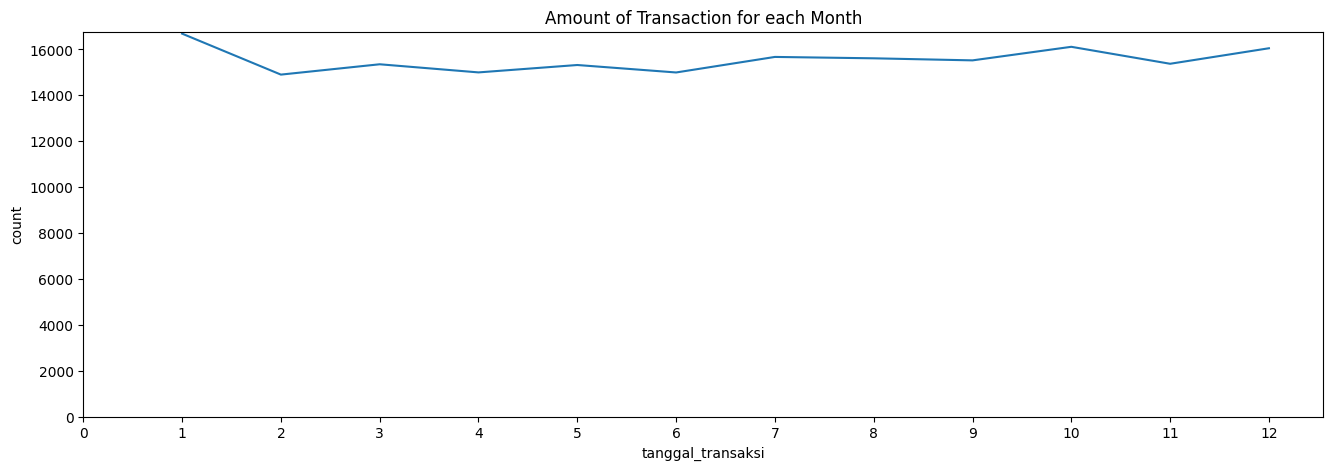

In [12]:
plt.figure(figsize=(16,5))
sns.lineplot(dataset['tanggal_transaksi'].dt.month.value_counts().sort_index())
plt.xticks(range(0,12+1))
plt.ylim(0)
plt.title('Amount of Transaction for each Month')
plt.show()

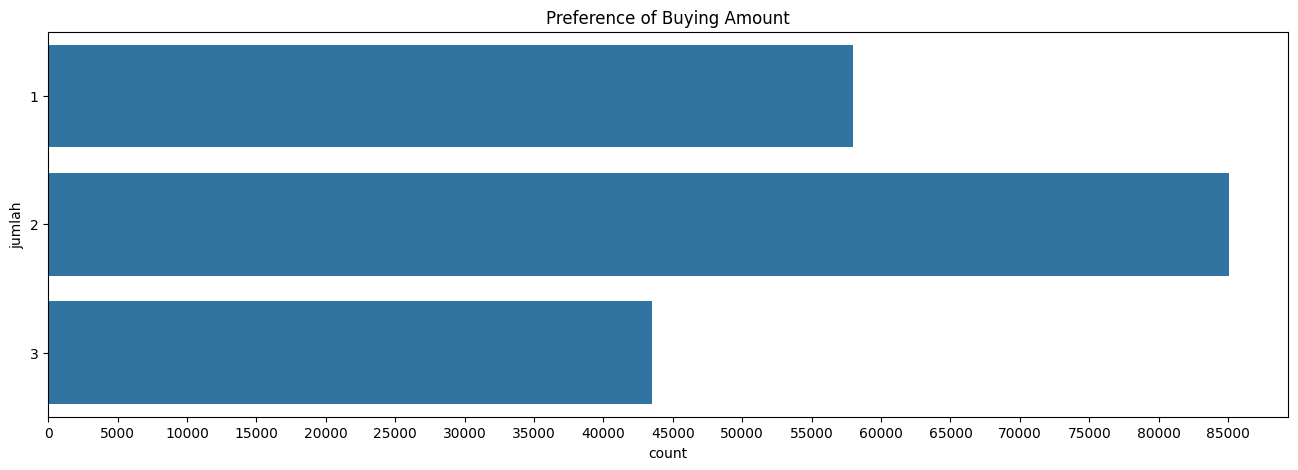

In [13]:
plt.figure(figsize=(16,5))
sns.barplot(dataset['jumlah'].value_counts(), orient='h')
plt.xticks(range(0,90000,5000))
plt.title('Preference of Buying Amount')
plt.show()

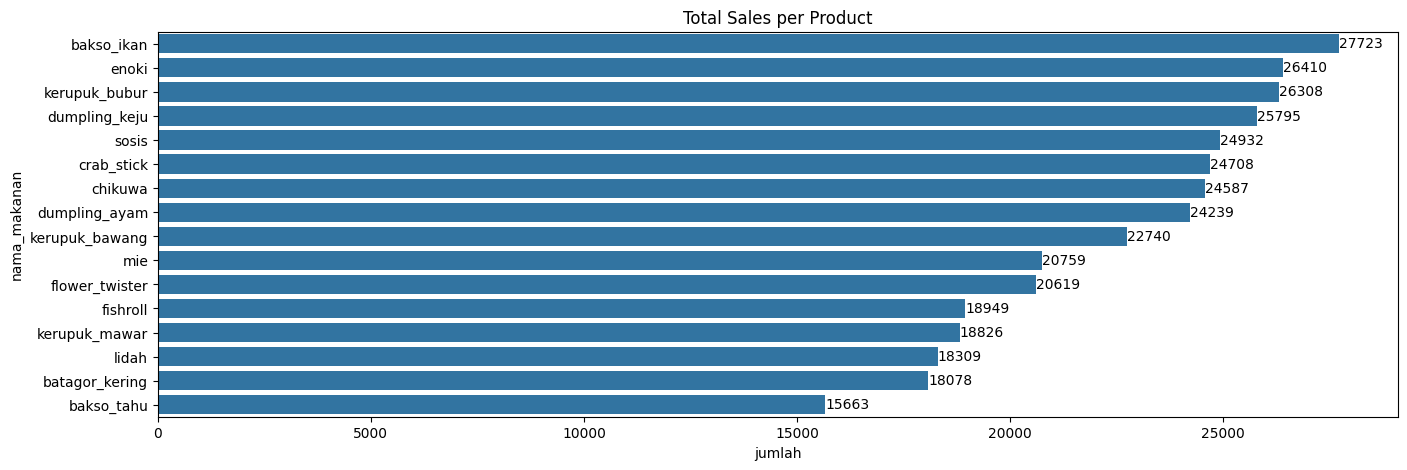

In [14]:
plt.figure(figsize=(16,5))
figure = sns.barplot(
    data=dataset[['nama_makanan', 'jumlah']].groupby('nama_makanan').sum().reset_index().sort_values('jumlah', ascending=False),
    y='nama_makanan', 
    x='jumlah',
    orient='h',)
figure.bar_label(figure.containers[0])
plt.title('Total Sales per Product')
plt.show()

# Data Preprocessing

Because we do not need the amount of transaction, we will use transaction id and product variables.

In [15]:
dataset_clean = dataset[['id_transaksi','nama_makanan','jumlah']].copy()

In [16]:
crosstab = pd.crosstab(index=dataset_clean['id_transaksi'], columns=dataset_clean['nama_makanan'])

In [17]:
print(crosstab.head(15).T)

id_transaksi    1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
nama_makanan                                                              
bakso_ikan       1   1   1   0   1   1   1   1   1   1   0   1   1   1   0
bakso_tahu       1   0   0   1   1   0   0   1   0   1   0   0   1   0   1
batagor_kering   1   1   1   1   0   0   0   1   0   1   1   0   0   1   1
chikuwa          1   0   1   1   1   0   0   0   1   1   1   1   1   1   0
crab_stick       0   1   1   1   1   0   0   1   0   0   1   1   0   1   1
dumpling_ayam    0   1   0   0   1   1   0   1   1   1   1   1   1   1   1
dumpling_keju    1   0   1   1   0   1   1   0   0   1   1   1   1   1   1
enoki            1   1   1   1   1   1   1   0   1   1   1   1   1   0   0
fishroll         0   1   0   0   1   0   1   1   0   1   1   0   1   1   1
flower_twister   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1
kerupuk_bawang   0   1   0   1   0   1   0   0   1   1   0   1   0   0   0
kerupuk_bubur    0   1   

In [18]:
def boolean(x):
    if x == 0:
        return False
    elif x == 1:
        return True

The `boolean` function is to make binary number into boolean.

# Modeling

In [19]:
# library for association rule mining
from mlxtend.frequent_patterns import apriori, association_rules

In [20]:
sup = 0.4
apriori_rule = apriori(crosstab.map(boolean), min_support=sup, use_colnames=True)
print(apriori_rule.sort_values('support', ascending=False).head(10))

     support          itemsets
0   0.728188      (bakso_ikan)
3   0.708292         (chikuwa)
6   0.649243   (dumpling_keju)
7   0.648114           (enoki)
11  0.629249   (kerupuk_bubur)
15  0.614856           (sosis)
5   0.587689   (dumpling_ayam)
10  0.574671  (kerupuk_bawang)
4   0.556396      (crab_stick)
9   0.535567  (flower_twister)


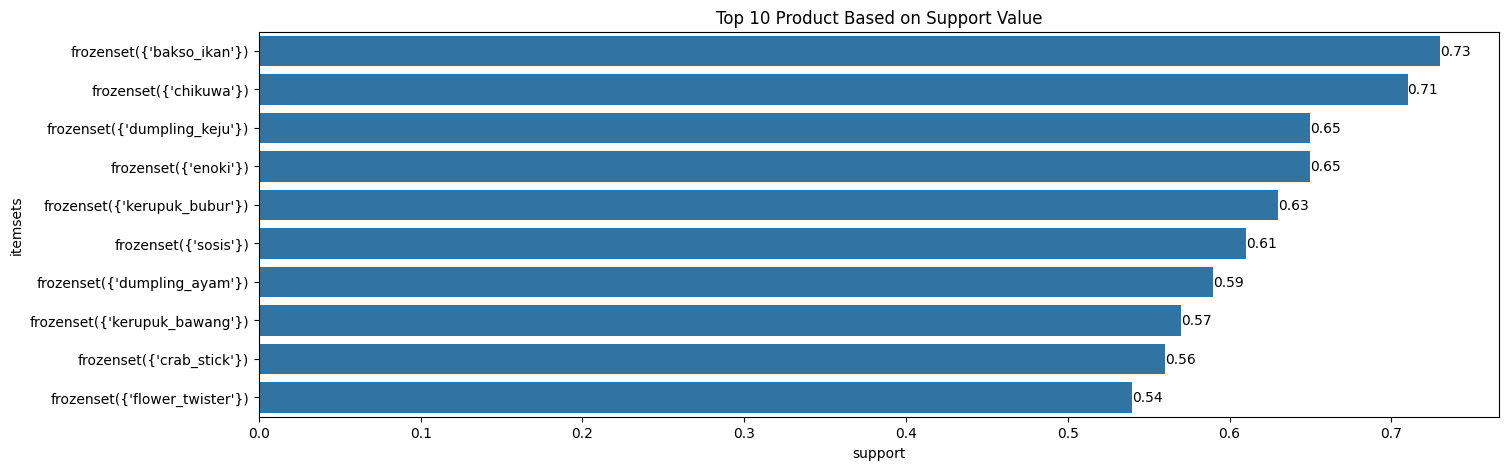

In [21]:
plt.figure(figsize=(16,5))
figure = sns.barplot(apriori_rule.sort_values('support', ascending=False).head(10).round(2), y='itemsets', x='support')
figure.bar_label(figure.containers[0])
plt.title('Top 10 Product Based on Support Value')
plt.show()

We see the highest support of itemsets is bakso ikan which is the most popular product, followed by chikuwa.

In [22]:
print(association_rules(
    apriori_rule, 
    num_itemsets=len(crosstab), 
    metric='support', 
    min_threshold=0.45,
    return_metrics=['support', 'confidence', 'lift']).sort_values(['support', 'confidence', 'lift'], ascending=False).round(3))

        antecedents      consequents  support  confidence   lift
1         (chikuwa)     (bakso_ikan)    0.516       0.729  1.001
0      (bakso_ikan)        (chikuwa)    0.516       0.709  1.001
2   (dumpling_keju)     (bakso_ikan)    0.474       0.730  1.003
3      (bakso_ikan)  (dumpling_keju)    0.474       0.651  1.003
4           (enoki)     (bakso_ikan)    0.471       0.727  0.998
5      (bakso_ikan)          (enoki)    0.471       0.647  0.998
7   (kerupuk_bubur)     (bakso_ikan)    0.462       0.734  1.008
6      (bakso_ikan)  (kerupuk_bubur)    0.462       0.634  1.008
10  (dumpling_keju)        (chikuwa)    0.460       0.709  1.001
11        (chikuwa)  (dumpling_keju)    0.460       0.650  1.001
12          (enoki)        (chikuwa)    0.459       0.708  1.000
13        (chikuwa)          (enoki)    0.459       0.648  1.000
9           (sosis)     (bakso_ikan)    0.452       0.735  1.009
8      (bakso_ikan)          (sosis)    0.452       0.621  1.009


# Insights

## Interpretation and Reporting

**Bakso ikan and chikuwa domination:**
- Bakso ikan and chikuwa appear as the most frequent items bought together, with a support of 51.6%. This shows that both are the main products customers order.
- High confidence shows that if one of them is in the basket, there is a high probability that the other item is also in the basket.

**Strong Companion Items:**
- Dumpling keju, enoki, kerupuk bubur, and sosis are also bought together with bakso ikan and chikuwa, showing customer preferences in choosing other toppings.
- High confidence for the items to bakso ikan (consequent) shows that bakso ikan is the most bought item and other items are companion items.

**Lift Ratio Close to 1** shows that items are bought independently but are still often bought together. This indicates that the popularity of the items is quite even.

## Action

**Optimal Bundling Strategy**
- Create a variety of packages that combine bakso ikan and chikuwa with popular companion items.
- For example, a frugal package (bakso ikan, chikuwa, dumpling keju, enoki, and kerupuk bubur).
- And offer the packages with an interesting price rather than items bought separately.

**Strategic Placement of Toppings**
- Arrange the topping display in such a way that bakso ikan and chikuwa are in the most prominent position.
- Place companion items around them to make it easier for customers to take them.
- Give labels for bakso ikan and chikuwa, like "matched pair" or "favorite toppings."

**Targeted Promotion**
- Make promotions for companion items, like "add enoki for only Rp2000."
- Offer one topping extra for free if you buy all toppings or a minimum of Rp35000.
- Give a loyalty program, like one free complete package after getting 10 visit stamps.

# Further Analysis

- Do clustering analysis to segment customers based on their characteristics.
- Conduct causal impact analysis to forecast the sales if the marketing team don't apply the insights market basket analysis.
- Perform regression analysis to predict sales for next couple of months.